# The XOR Classification Problem

It conisits in a non linear classification problem where the dataset is defined as follow:
- $y^{(i)}=1$ if $x_1^{(i)}*x_2^{(i)} > 0 $
- $y^{(i)}=0$ otherwise

The goal of this notebook is to solve the XOR problem with **Neural Networks** and showcase the importance of activation functions.

In [2]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import plot_decision_regions

### 1. Get the data

In [4]:
n = 250 # number of samples

X = np.random.uniform(low=-1.0, high=1.0, size = (n,2))
Y = np.ones(n)
Y[X[:,0]*X[:,1]<0] = 0

#### Plot the data

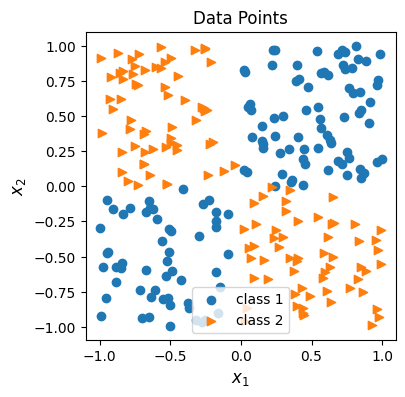

In [6]:
class_1 = X[X[:,0]*X[:,1]>0] 
class_2 = X[X[:,0]*X[:,1]<0]

fig = plt.figure(figsize=(4,4))
plt.scatter(class_1[:,0], class_1[:,1], marker='o', label = 'class 1')
plt.scatter(class_2[:,0], class_2[:,1], marker='>', label = 'class 2')
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.legend()
plt.title("Data Points");

### 2. Prepare Dataset

In [8]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [9]:
torch.manual_seed(1)

# 1. convert data into tensor
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y)

# 2. seperate data in train test
X_train, X_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.33, random_state=42)

# 3. normalize data with train data
# Not really necessary here because the data are generated following uniform distribution
# Careful, avoid data leakage by normalizing test data with training data as well
# Test data must be untouched
X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_train.mean())/X_train.std()

# 4. create data set and dataloader
train_ds = TensorDataset(X_train_norm, y_train)
train_dl = DataLoader(dataset = train_ds, batch_size = 20, shuffle = True)

### 3. Build the Model

In [11]:
class Model(nn.Module):
    """ Create Neural Network"""
    
    def __init__(self, hidden, activation = None, input_size=2, output_size=2):
        super().__init__()
        
        layers_list = []
        n_in = input_size
        
        for size in hidden:
            layers_list.append(nn.Linear(n_in, size))
            if activation:
                layers_list.append(activation)
            n_in = size
                
        layers_list.append(nn.Linear(n_in, output_size))
        self.layers = nn.Sequential(*layers_list)
        
    def forward(self, x):
        x = self.layers(x)
        return x # softmax is applied within loss function

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32) # convert into tensor in case it is not
        pred = torch.argmax(self.forward(x), dim=1)
        return pred

### 4. Train the model 

In [13]:
def train_model(model, train_dl, num_epochs=150):
    
    """ Train the model over num_epochs and return accuracy and loss history """
    
    learning_rate = 0.001
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    loss_log = [0]*num_epochs
    accuracy_log = [0]*num_epochs

    for epoch in range(num_epochs):

        # go through all data in batch
        for batch in train_dl:
            X_batch, y_batch = batch

            y_pred = model.forward(X_batch)
            loss = loss_fn(y_pred, y_batch.long())

            # compute gradient
            loss.backward()

            # update parameters using gradient
            optimizer.step()

            # reset the gradient to zero
            optimizer.zero_grad()

            loss_log[epoch] += loss.item()*y_batch.size(0) # add the loss of each item in batch
            is_correct = (torch.argmax(y_pred,dim=1) == y_batch).float()
            accuracy_log[epoch] += is_correct.sum()

        # Keep track for of loss for each batch and average on number of batch
        loss_log[epoch] /= len(train_dl.dataset)         
        accuracy_log[epoch] /= len(train_dl.dataset)   
    
    return loss_log, accuracy_log

### 5. Measure Model Performance

The goal here is to see the impact of the activations functions. Accuracy evolution over training epochs and decision boundary with test set will be plotted.


In [16]:
def plot(model, accuracy, title):
    """ Plot model accuracy through epochs and decision boundary """
    
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Training Accuracy")
    plt.plot(accuracy)
    
    ax = fig.add_subplot(1,2,2)
    plot_decision_regions(X = X_test_norm.numpy(), y = y_test.numpy().astype(np.int32), clf=model)

    plt.suptitle(title);

In [17]:
def launch_training(models):
    """ Launch training and retrieve accuracies """
    accuracies = []
    for model in models:
        _, accuracy = train_model(model, train_dl)
        accuracies.append(accuracy)

    return accuracies

#### 5.1 Linear Models

In [19]:
models = [
    Model([8], activation = None),        # one layer linear 
    Model([8,8,8], activation = None),    # deep linear
]
accuracies = launch_training(models)

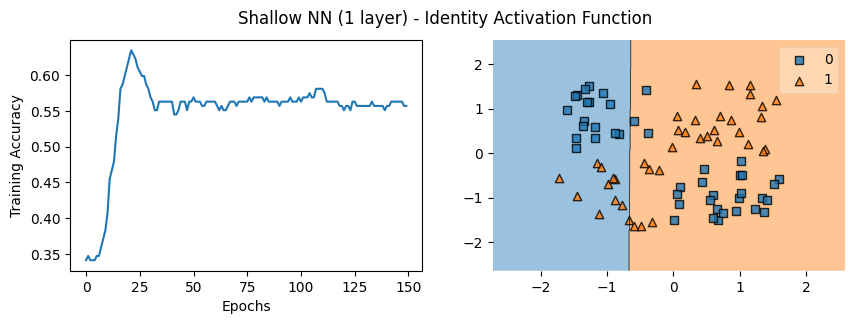

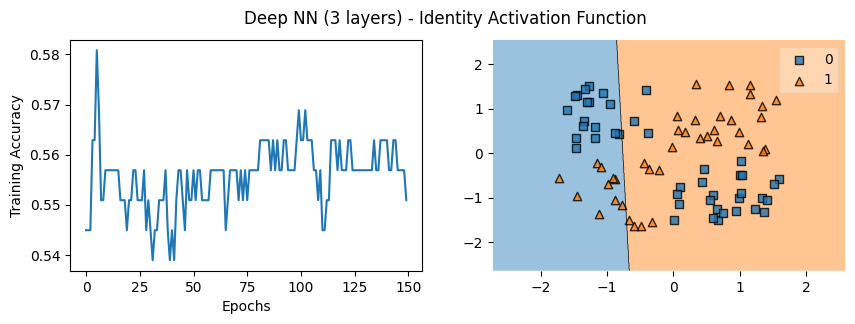

In [20]:
plot(models[0], accuracies[0], title = "Shallow NN (1 layer) - Identity Activation Function")
plot(models[1], accuracies[1], title = "Deep NN (3 layers) - Identity Activation Function")

No matter how deep is the model the model performance does not increase. A linear model cannot cactch a non linear relationship.

#### 5.2 Non Linear Shallow Models

In [23]:
models = [
    Model([8], activation = nn.ReLU()),        # one layer ReLU
    Model([8], activation = nn.Sigmoid()),     # one layer Sigmoid
    Model([8], activation = nn.Tanh()),        # one layer tanh
]
accuracies = launch_training(models)

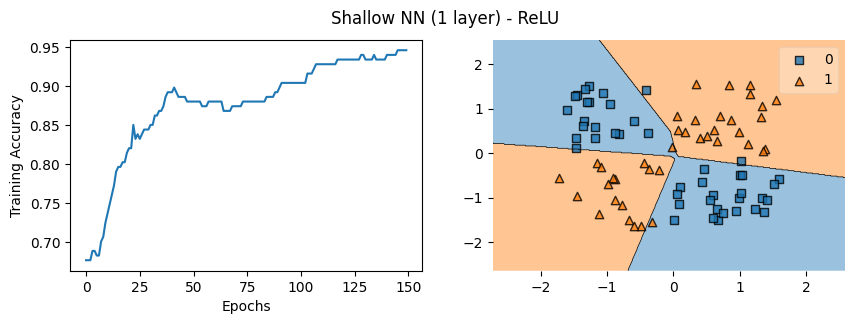

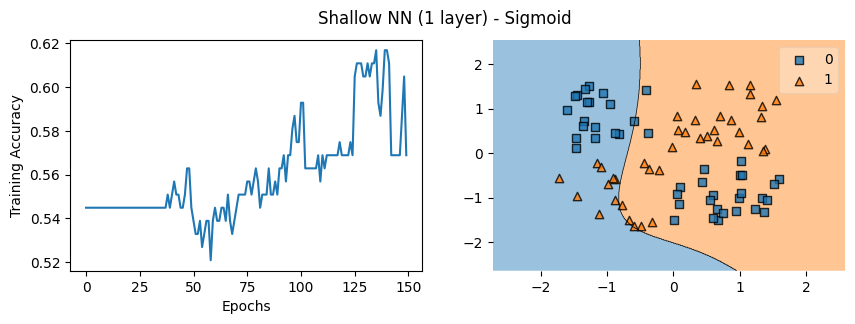

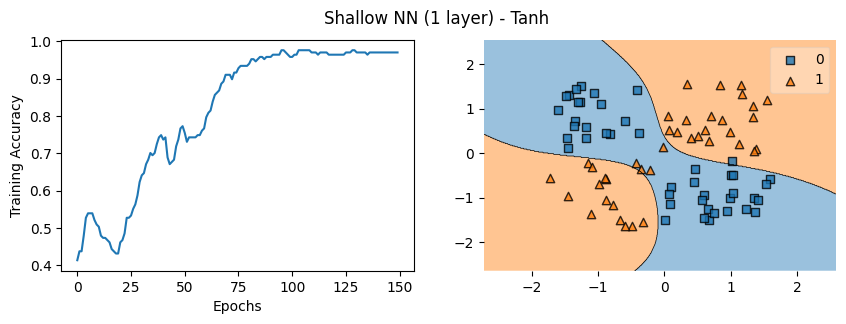

In [24]:
plot(models[0], accuracies[0], title = "Shallow NN (1 layer) - ReLU")
plot(models[1], accuracies[1], title = "Shallow NN (1 layer) - Sigmoid")
plot(models[2], accuracies[2], title = "Shallow NN (1 layer) - Tanh")

All models are able to catch non linear relationships, the decision boundary being non linear. However, the **Sigmoïd** model gives poor results while **Tanh** and **ReLU** give good results.

#### 5.3 Non Linear Deep Models

In [46]:
models = [
    Model([32, 16, 8, 4], activation = nn.ReLU()),        # ReLU
    Model([32, 16, 8, 4], activation = nn.Sigmoid()),     # Sigmoid
    Model([32, 16, 8, 4], activation = nn.Tanh()),        # Tanh
]
accuracies = launch_training(models)

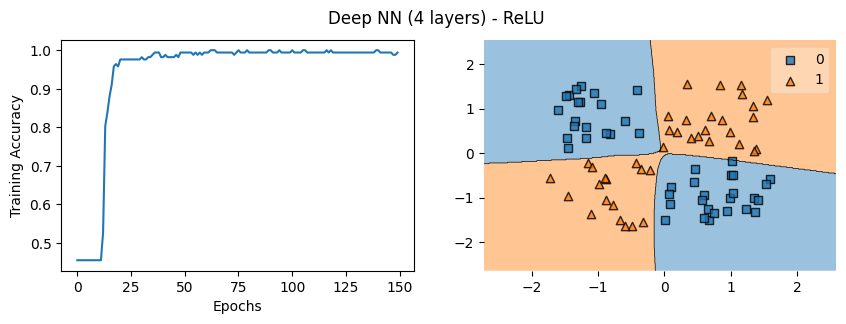

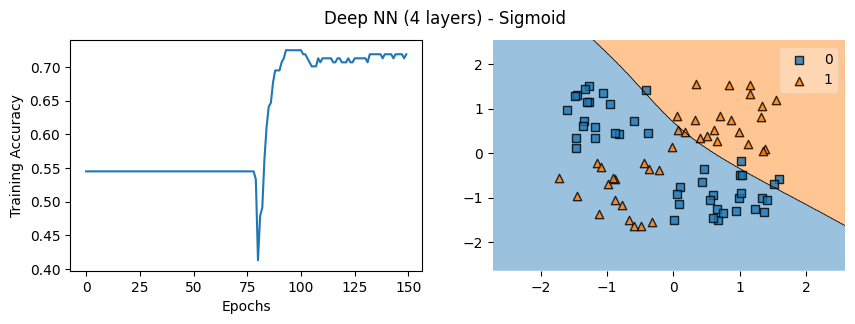

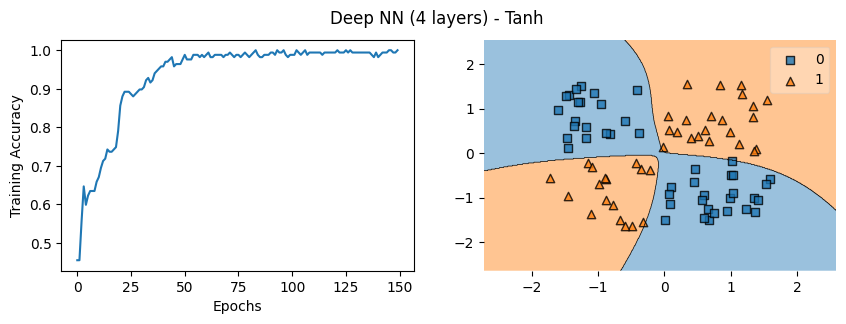

In [47]:
plot(models[0], accuracies[0], title = "Deep NN (4 layers) - ReLU")
plot(models[1], accuracies[1], title = "Deep NN (4 layers) - Sigmoid")
plot(models[2], accuracies[2], title = "Deep NN (4 layers) - Tanh")

Adding layers doesn't improve the **Sigmoïd** model performance. However both the **ReLU** and **Tanh** models converge earlier on the training set. 